# Deep Neural Network for Smile Detection

### Two hidden layer DNN: 200, 200. Dropout layers with rates of 20%, 30% and 50% were added. L1, L2 and max norm reg. were also tried. All dropouts and L1 reg. improved the model, when we compare the F1 scores. 

##  Import packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from time import time
import os
import tensorflow as tf
from time import time

from pylab import rcParams
rcParams['figure.figsize'] = 12,10

import cv2

##  Fetch dataset

In [2]:
#All images provided to the classifier should have fixed and equal sizes
dim = (64, 64)

def fetch_category_images(path_to_subject, subject_number):
    
    X = np.array([])
    index = 0
    for subject_img in os.listdir(path_to_subject): #for each image in this subject's folder
        img_path = os.path.join(path_to_subject, subject_img)
        if img_path.endswith(".pgm") or img_path.endswith(".png") or img_path.endswith(".jpg") or img_path.endswith(".jpeg"):
            #Read image, convert it to grayscale and resize every image to a fixed size  
            img = cv2.resize(cv2.imread(img_path, 0), dim, interpolation = cv2.INTER_AREA) 
            
            #img_data = img.ravel()  #Flatten each image, so that each sample is a 1D vector
            img_data = img[np.newaxis, :, :]
            X = img_data if not X.shape[0] else np.vstack((X, img_data))
            index += 1

    y = np.empty(index, dtype = int) #index = total no. of samples
    y.fill(subject_number)  #add labels
    return X, y

def fetch_data(dataset_path):

    # Get a the list of folder names in the path to dataset
    labels_list = [d for d in os.listdir(dataset_path) if "." not in str(d)]
    X = np.empty([0, dim[0], dim[1]])
    y = np.empty([0])

    for i in range(0, len(labels_list)):  #for each person
        subject = str(labels_list[i])  #person i in list of ppl
        path_to_subject = os.path.join(dataset_path, subject) #full path to this person's directory
        
        #Read all images in this folder (all images of this person)
        X_, y_ = fetch_category_images(path_to_subject, i)
        X = np.concatenate((X, X_), axis=0)
        y = np.append(y, y_)
        print("Class {}: '{}', {} images loaded".format(i, labels_list[i], X_.shape[0]))

    return X, y, labels_list

# Load training data 
dataset_path = "Smile_dataset/"
X, y, labels_list  = fetch_data(dataset_path)

Class 0: 'negatives', 9475 images loaded
Class 1: 'positives', 3690 images loaded


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

n_classes = len(np.unique(y))
print("Dataset consists of {} samples and  {} classes".format(X.shape[0], n_classes))
encoder = OneHotEncoder()
labels = encoder.fit_transform(np.reshape(y, (-1, 1))).toarray()

print("Data: {} and one hot encoded labels: {}".format(X.shape, labels.shape))                                                                                           
print(" ")
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20, random_state=42)
print("Training data {}, test data {}".format(X_train.shape,X_test.shape))

Dataset consists of 13165 samples and  2 classes
Data: (13165, 64, 64) and one hot encoded labels: (13165, 2)
 
Training data (10532, 64, 64), test data (2633, 64, 64)


##  Reduce dimensionality

In [26]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95, whiten=True).fit(X_train)  #preserve 95% of variance
n_comp = pca.n_components_
print("PCA reduced dimensionality from {} to {}".format(X_train.shape[1], n_comp))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("New training and test data", X_train_pca.shape, "and", X_test_pca.shape)

PCA reduced dimensionality from 4096 to 176
New training and test data (10532, 176) and (2633, 176)


## Train DNN

In [37]:
# tf.reset_default_graph()

In [38]:
n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64

hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, kernel_initializer = xavier_init)

hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, kernel_initializer = xavier_init)

logits = tf.layers.dense(hidden2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn2_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.890625, train loss = 0.23237420408798404
Validation loss: 0.33051742291536074, minimum loss: 0.33051742291536074, validation accuracy: 0.8613748550415039
 
EPOCH 1
Train accuracy = 0.921875, train loss = 0.21335828469392315
Validation loss: 0.3253343029702102, minimum loss: 0.3253343029702102, validation accuracy: 0.8625142574310303
 
EPOCH 2
Train accuracy = 0.96875, train loss = 0.08648391484861592
Validation loss: 0.3387492552150481, minimum loss: 0.3253343029702102, validation accuracy: 0.8621344566345215
 
EPOCH 3
Train accuracy = 0.96875, train loss = 0.09037484348833666
Validation loss: 0.3751939982575263, minimum loss: 0.3253343029702102, validation accuracy: 0.8632738590240479
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.0439379057275147
Validation loss: 0.4292862427102497, minimum loss: 0.3253343029702102, validation accuracy: 0.865172803401947
 
EPOCH 5
Train accuracy = 1.0, train loss = 0.01693326135333693
Validation loss: 0.456103084946341

##  Evaluate the model

In [42]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.862514
Classification report : 
             precision    recall  f1-score   support

  negatives       0.89      0.92      0.91      1937
  positives       0.77      0.69      0.73       696

avg / total       0.86      0.86      0.86      2633



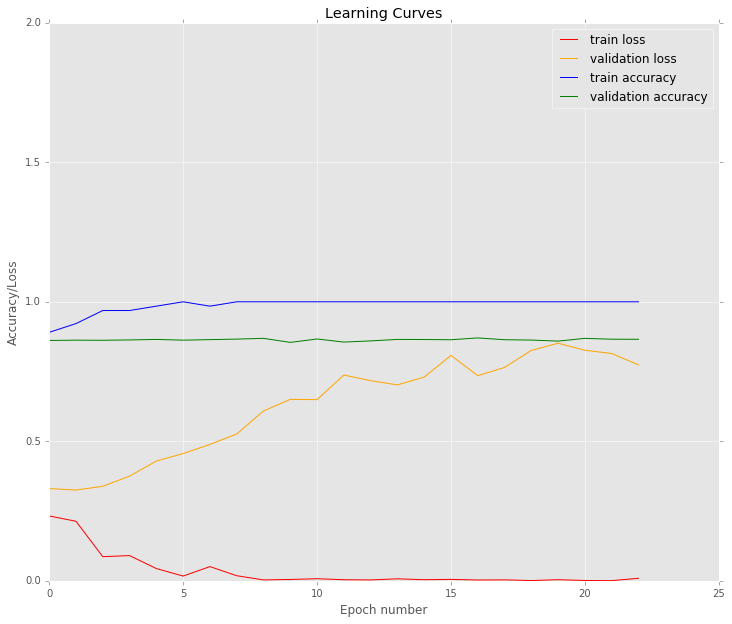

In [46]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

### The validation loss starts diverging from the train loss right from epoch #1. This is a clear indication of overfitting, which is also confirmed by a train accuracy that is way more that test accuracy. 

# Fix overfitting by regularization

In [48]:
tf.reset_default_graph()

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp
drop_rate = 0.20

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64
training_ = tf.placeholder_with_default(False, shape=[])

hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, kernel_initializer = xavier_init)

drop_layer1 = tf.layers.dropout(hidden1, drop_rate, training = training_)

hidden2 = tf.layers.dense(drop_layer1, n_hidden2, activation = tf.nn.relu, kernel_initializer = xavier_init)

drop_layer2 = tf.layers.dropout(hidden2, drop_rate, training = training_)

logits = tf.layers.dense(drop_layer2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn_drop1_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch, training_: False})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.875, train loss = 0.343413358988537
Validation loss: 0.34131422740274747, minimum loss: 0.34131422740274747, validation accuracy: 0.8621344566345215
 
EPOCH 1
Train accuracy = 0.96875, train loss = 0.1305336982904646
Validation loss: 0.32406641040241224, minimum loss: 0.32406641040241224, validation accuracy: 0.8739081025123596
 
EPOCH 2
Train accuracy = 0.9375, train loss = 0.16532739658607104
Validation loss: 0.35767125678464456, minimum loss: 0.32406641040241224, validation accuracy: 0.8625142574310303
 
EPOCH 3
Train accuracy = 0.96875, train loss = 0.127018735198894
Validation loss: 0.34517023183189494, minimum loss: 0.32406641040241224, validation accuracy: 0.8739081025123596
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.05667345268128231
Validation loss: 0.36168758154590736, minimum loss: 0.32406641040241224, validation accuracy: 0.8761868476867676
 
EPOCH 5
Train accuracy = 1.0, train loss = 0.018347044432135053
Validation loss: 0.41173482297292

##  Evaluate the model

In [49]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.873908
Classification report : 
             precision    recall  f1-score   support

  negatives       0.91      0.92      0.91      1937
  positives       0.77      0.74      0.76       696

avg / total       0.87      0.87      0.87      2633



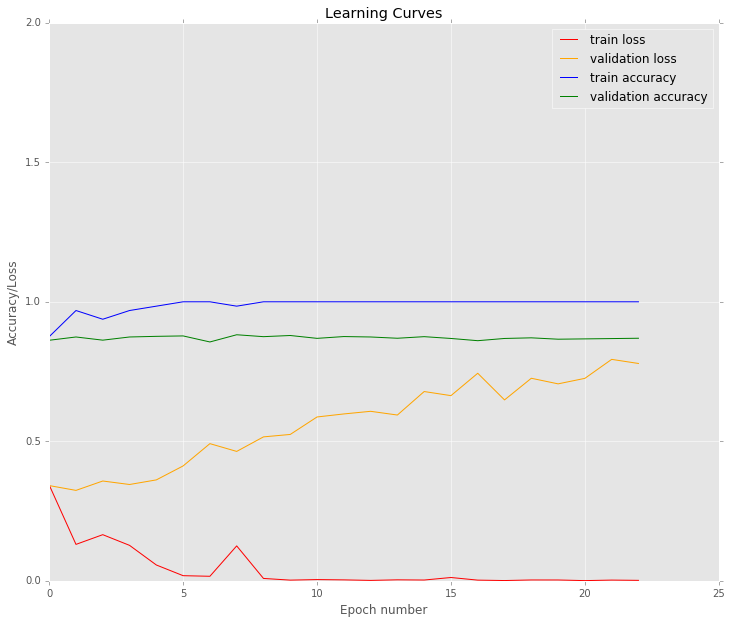

In [50]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

### The train and test accuray were 100 and 86.25. With 20% dropout, the numbers are 100  and 87.39. The precision, recall and F1 scores improved from 86 to 87. But as the validation loss stil diverges from train loss, the model is still overfitting. Let's try to imporve the generazibility of the model by increasing the dropout.

#  30% dropout

In [51]:
tf.reset_default_graph()

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp
drop_rate = 0.30

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64
training_ = tf.placeholder_with_default(False, shape=[])

hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, kernel_initializer = xavier_init)

drop_layer1 = tf.layers.dropout(hidden1, drop_rate, training = training_)

hidden2 = tf.layers.dense(drop_layer1, n_hidden2, activation = tf.nn.relu, kernel_initializer = xavier_init)

drop_layer2 = tf.layers.dropout(hidden2, drop_rate, training = training_)

logits = tf.layers.dense(drop_layer2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn_drop2_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch, training_: False})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.984375, train loss = 0.1490913330790576
Validation loss: 0.32624965628760894, minimum loss: 0.32624965628760894, validation accuracy: 0.8594759106636047
 
EPOCH 1
Train accuracy = 0.953125, train loss = 0.20279344995128556
Validation loss: 0.3258499932054209, minimum loss: 0.3258499932054209, validation accuracy: 0.8659324049949646
 
EPOCH 2
Train accuracy = 0.9375, train loss = 0.20093703523345646
Validation loss: 0.3540438321297741, minimum loss: 0.3258499932054209, validation accuracy: 0.8682111501693726
 
EPOCH 3
Train accuracy = 0.984375, train loss = 0.06872752906829527
Validation loss: 0.3981297426626257, minimum loss: 0.3258499932054209, validation accuracy: 0.87542724609375
 
EPOCH 4
Train accuracy = 1.0, train loss = 0.03610621267059102
Validation loss: 0.4151309203638431, minimum loss: 0.3258499932054209, validation accuracy: 0.8712494969367981
 
EPOCH 5
Train accuracy = 1.0, train loss = 0.01542905574440202
Validation loss: 0.45423847663474415, mi

##  Evaluate the model

In [52]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.865932
Classification report : 
             precision    recall  f1-score   support

  negatives       0.91      0.91      0.91      1937
  positives       0.74      0.75      0.75       696

avg / total       0.87      0.87      0.87      2633



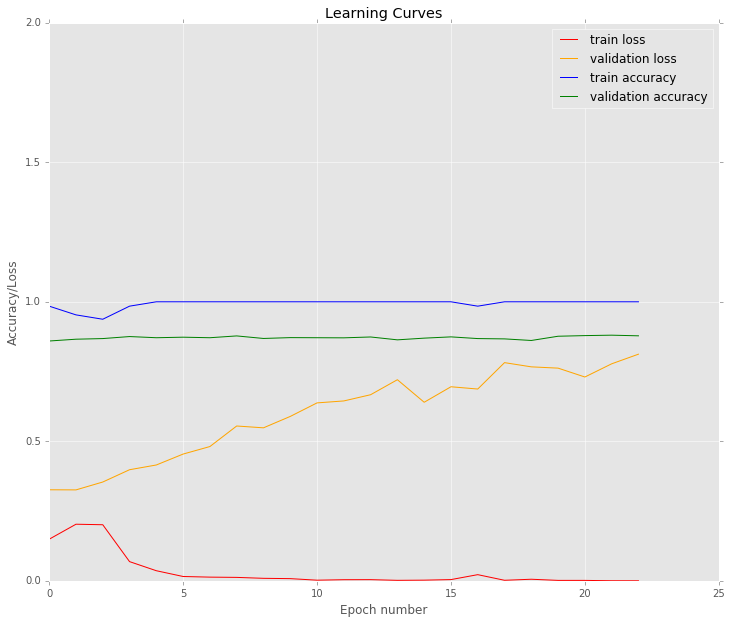

In [53]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

## 50% dropout

In [54]:
tf.reset_default_graph()

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp
drop_rate = 0.50

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64
training_ = tf.placeholder_with_default(False, shape=[])

hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, kernel_initializer = xavier_init)

drop_layer1 = tf.layers.dropout(hidden1, drop_rate, training = training_)

hidden2 = tf.layers.dense(drop_layer1, n_hidden2, activation = tf.nn.relu, kernel_initializer = xavier_init)

drop_layer2 = tf.layers.dropout(hidden2, drop_rate, training = training_)

logits = tf.layers.dense(drop_layer2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn_drop2_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch, training_: False})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.96875, train loss = 0.243778509531347
Validation loss: 0.33300843305097255, minimum loss: 0.33300843305097255, validation accuracy: 0.857197105884552
 
EPOCH 1
Train accuracy = 0.9375, train loss = 0.2109563538083019
Validation loss: 0.3271111985608813, minimum loss: 0.3271111985608813, validation accuracy: 0.8712494969367981
 
EPOCH 2
Train accuracy = 1.0, train loss = 0.052012612914669396
Validation loss: 0.3532134092752024, minimum loss: 0.3271111985608813, validation accuracy: 0.8647930026054382
 
EPOCH 3
Train accuracy = 0.984375, train loss = 0.06017238746195208
Validation loss: 0.3778833077874828, minimum loss: 0.3271111985608813, validation accuracy: 0.8685909509658813
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.08398463286252857
Validation loss: 0.38081611117988395, minimum loss: 0.3271111985608813, validation accuracy: 0.8792251944541931
 
EPOCH 5
Train accuracy = 1.0, train loss = 0.01973013363697742
Validation loss: 0.4574925879579796, min

##  Evaluate the model

In [55]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.871249
Classification report : 
             precision    recall  f1-score   support

  negatives       0.92      0.91      0.91      1937
  positives       0.75      0.77      0.76       696

avg / total       0.87      0.87      0.87      2633



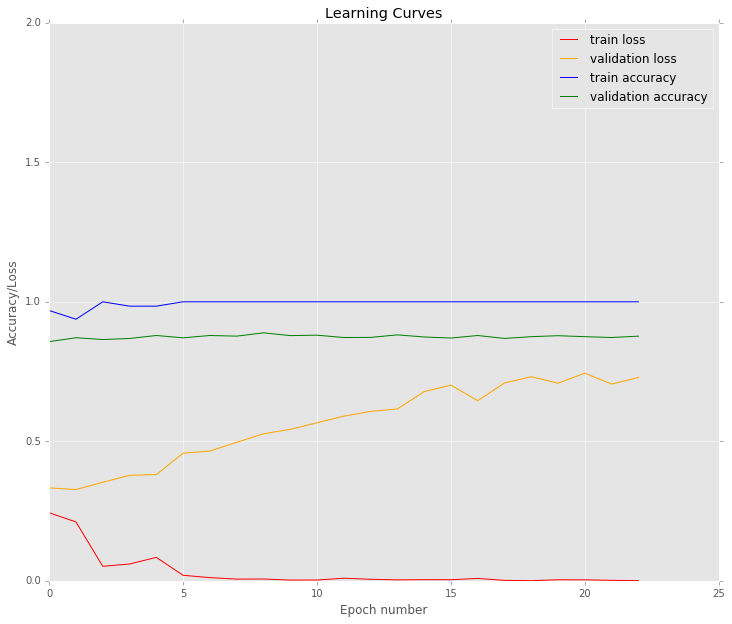

In [56]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

## Dropout does not seem to help much. Let's try L1 regularization.

In [63]:
tf.reset_default_graph()

from functools import partial

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64

scale_val = 0.001
new_dense_layer = partial(tf.layers.dense, kernel_initializer = xavier_init,
                          kernel_regularizer = tf.contrib.layers.l1_regularizer(scale_val), 
                          activation = tf.nn.relu)

dense_layer1 = new_dense_layer(X, n_hidden1)

dense_layer2 = new_dense_layer(dense_layer1, n_hidden2)

logits = tf.layers.dense(dense_layer2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn_l1_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.921875, train loss = 0.17607190823252583
Validation loss: 0.31492193008321845, minimum loss: 0.31492193008321845, validation accuracy: 0.8678313493728638
 
EPOCH 1
Train accuracy = 0.875, train loss = 0.25905578378274463
Validation loss: 0.30434788268778906, minimum loss: 0.30434788268778906, validation accuracy: 0.8685909509658813
 
EPOCH 2
Train accuracy = 0.984375, train loss = 0.08147404177114202
Validation loss: 0.3138236489394741, minimum loss: 0.30434788268778906, validation accuracy: 0.8739081025123596
 
EPOCH 3
Train accuracy = 0.96875, train loss = 0.06338482945999853
Validation loss: 0.3400942669224716, minimum loss: 0.30434788268778906, validation accuracy: 0.8799847960472107
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.06271308778006057
Validation loss: 0.3720229981714435, minimum loss: 0.30434788268778906, validation accuracy: 0.8720090985298157
 
EPOCH 5
Train accuracy = 1.0, train loss = 0.017988990551908553
Validation loss: 0.399089394

##  Evaluate the model

In [64]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.868591
Classification report : 
             precision    recall  f1-score   support

  negatives       0.91      0.91      0.91      1937
  positives       0.75      0.75      0.75       696

avg / total       0.87      0.87      0.87      2633



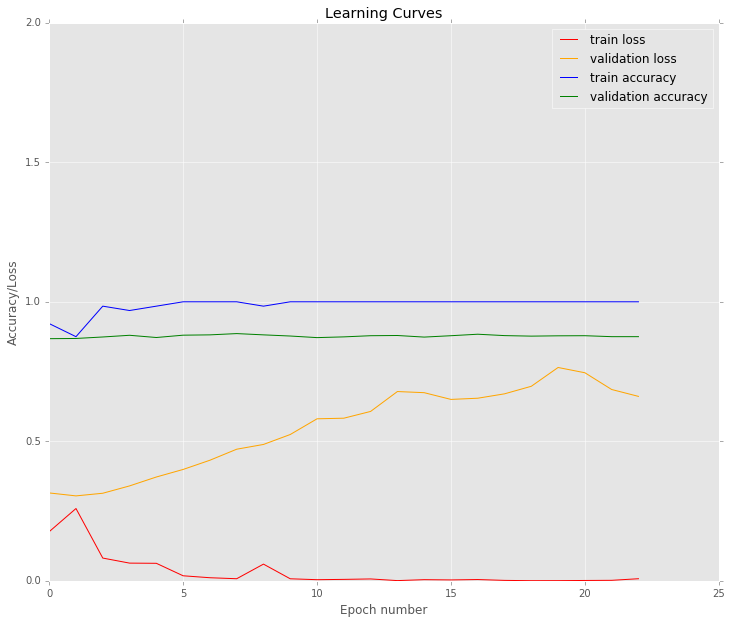

In [65]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

## Increase the penalty value in L1 regularization.

In [66]:
tf.reset_default_graph()

from functools import partial

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64

scale_val = 0.01
new_dense_layer = partial(tf.layers.dense, kernel_initializer = xavier_init,
                          kernel_regularizer = tf.contrib.layers.l1_regularizer(scale_val), 
                          activation = tf.nn.relu)

dense_layer1 = new_dense_layer(X, n_hidden1)

dense_layer2 = new_dense_layer(dense_layer1, n_hidden2)

logits = tf.layers.dense(dense_layer2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.01)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn_l1.1_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.953125, train loss = 0.14783868428323166
Validation loss: 0.3249439799153305, minimum loss: 0.3249439799153305, validation accuracy: 0.8685909509658813
 
EPOCH 1
Train accuracy = 0.859375, train loss = 0.247837388592021
Validation loss: 0.3269061228296298, minimum loss: 0.3249439799153305, validation accuracy: 0.8663122057914734
 
EPOCH 2
Train accuracy = 0.984375, train loss = 0.04753490368261171
Validation loss: 0.3681231203297917, minimum loss: 0.3249439799153305, validation accuracy: 0.8792251944541931
 
EPOCH 3
Train accuracy = 1.0, train loss = 0.04830932050923156
Validation loss: 0.33786846251771635, minimum loss: 0.3249439799153305, validation accuracy: 0.8799847960472107
 
EPOCH 4
Train accuracy = 0.9375, train loss = 0.11854612186358185
Validation loss: 0.40377052523974116, minimum loss: 0.3249439799153305, validation accuracy: 0.8666920065879822
 
EPOCH 5
Train accuracy = 0.9375, train loss = 0.1473693390879569
Validation loss: 0.4287811169495697, 

##  Evaluate the model

In [67]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.868591
Classification report : 
             precision    recall  f1-score   support

  negatives       0.90      0.92      0.91      1937
  positives       0.77      0.72      0.74       696

avg / total       0.87      0.87      0.87      2633



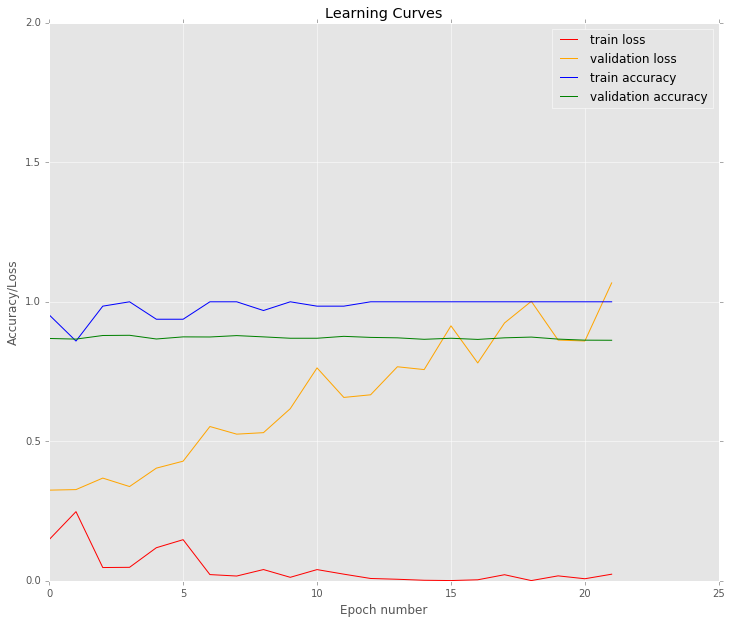

In [68]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

## Try L2 regularization with scale = 0.001 (same as the first L1 reg.)

In [69]:
tf.reset_default_graph()

from functools import partial

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64

scale_val = 0.01
new_dense_layer = partial(tf.layers.dense, kernel_initializer = xavier_init,
                          kernel_regularizer = tf.contrib.layers.l1_regularizer(scale_val), 
                          activation = tf.nn.relu)

dense_layer1 = new_dense_layer(X, n_hidden1)

dense_layer2 = new_dense_layer(dense_layer1, n_hidden2)

logits = tf.layers.dense(dense_layer2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn_l2_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.90625, train loss = 0.295680738048507
Validation loss: 0.3342476527492189, minimum loss: 0.3342476527492189, validation accuracy: 0.854918360710144
 
EPOCH 1
Train accuracy = 0.90625, train loss = 0.19649699284673613
Validation loss: 0.3249223173933267, minimum loss: 0.3249223173933267, validation accuracy: 0.8666920065879822
 
EPOCH 2
Train accuracy = 0.9375, train loss = 0.17983430689013122
Validation loss: 0.32579721492927227, minimum loss: 0.3249223173933267, validation accuracy: 0.8739081025123596
 
EPOCH 3
Train accuracy = 1.0, train loss = 0.036045876364430005
Validation loss: 0.3519595039941241, minimum loss: 0.3249223173933267, validation accuracy: 0.8678313493728638
 
EPOCH 4
Train accuracy = 0.984375, train loss = 0.03143680562966005
Validation loss: 0.374184633095782, minimum loss: 0.3249223173933267, validation accuracy: 0.8780858516693115
 
EPOCH 5
Train accuracy = 1.0, train loss = 0.022079668630915827
Validation loss: 0.4179080850822263, minim

##  Evaluate the model

In [70]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.866692
Classification report : 
             precision    recall  f1-score   support

  negatives       0.89      0.94      0.91      1937
  positives       0.80      0.67      0.73       696

avg / total       0.86      0.87      0.86      2633



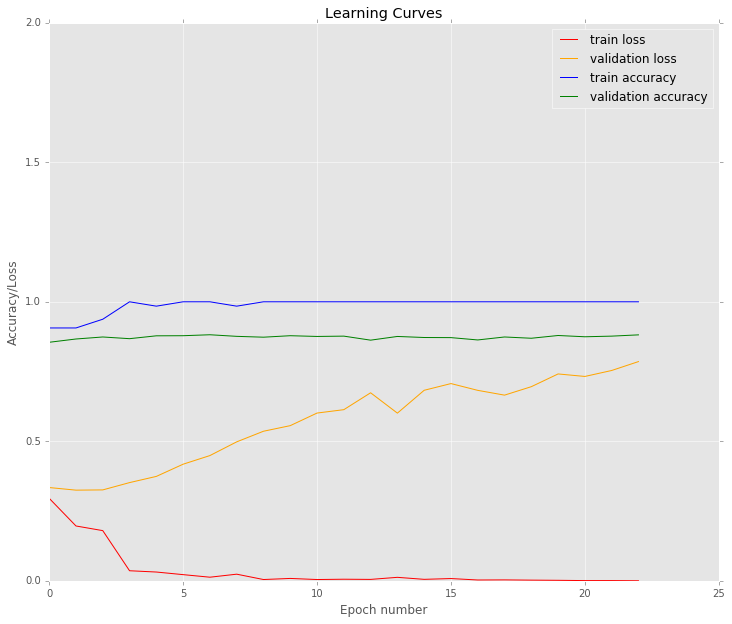

In [71]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()

## Max norm regularization

In [74]:
tf.reset_default_graph()

n_hidden1 = 200
n_hidden2 = 200

n_features = n_comp

xavier_init = tf.contrib.layers.xavier_initializer()

X = tf.placeholder(tf.float64, shape=(None, n_features)) #data is float64
y = tf.placeholder(tf.float64, shape=(None, n_classes))  #is float64

max_clip_value = 1.0

def dense_layer(input_layer, n_neurons, kernel_init, activation, name):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init, name = name)
    return fully_conn

dense_layer1 = dense_layer(X, n_hidden1, xavier_init, tf.nn.relu, "dense1")

dl1_weights = tf.get_default_graph().get_tensor_by_name("dense1/kernel:0")
clipped1 = tf.clip_by_norm(dl1_weights, clip_norm = max_clip_value, axes=1)
dl1_clipped = tf.assign(dl1_weights, clipped1)

dense_layer2 = dense_layer(dense_layer1, n_hidden2, xavier_init, tf.nn.relu, "dense2")

dl2_weights = tf.get_default_graph().get_tensor_by_name("dense2/kernel:0")
clipped2 = tf.clip_by_norm(dl2_weights, clip_norm = max_clip_value, axes=1)
dl2_clipped = tf.assign(dl2_weights, clipped2)

logits = tf.layers.dense(dense_layer2, n_classes)

prediction = tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer(0.001)
train_step = optimizer.minimize(loss)

correct_preds = tf.equal(tf.argmax(prediction,1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

saver = tf.train.Saver()

n_epochs = 100
batch_size = 64
n_train = X_train_pca.shape[0]
n_iter = n_train//batch_size
path = "./Smile_detection_dnn2_grad_clip_200"

train_loss_log, train_acc_log, val_loss_log, val_acc_log = ([] for i in range (4))

sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
init.run()

#initialize variables for early stopping
min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

start = time()
for epoch in range(n_epochs):
    for iteration in range(n_iter):
        rand_indices = np.random.choice(n_train, batch_size, replace = False)    
        X_batch, y_batch = X_train_pca[rand_indices], y_train[rand_indices]
        sess.run(train_step, feed_dict={X: X_batch, y: y_batch})
        
    train_loss, train_acc = sess.run([loss, accuracy], feed_dict={X: X_batch, y: y_batch})
    train_loss_log.append(train_loss)
    train_acc_log.append(train_acc)

    val_loss, val_acc, y_pred = sess.run([loss, accuracy, prediction], feed_dict={X: X_test_pca, y: y_test})
    val_loss_log.append(val_loss)
    val_acc_log.append(val_acc)
        
    # Early stopping 
        
    if val_loss < min_loss:
        save_path = saver.save(sess, path)
        min_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement > max_epochs_without_improvement:
            print("** EARLY STOPPING ** ")
            break
    print("EPOCH {}".format(epoch))
    print("Train accuracy = {}, train loss = {}".format(train_acc, train_loss))
    print("Validation loss: {}, minimum loss: {}, validation accuracy: {}".format(val_loss, min_loss, val_acc))
    print(" ")
    

print("Training took %f minutes"%(float(time() - start)/60.0))

saver.restore(sess, path)
acc_test = accuracy.eval(feed_dict={X: X_test_pca, y: y_test})
print("Final test accuracy = {}".format(acc_test))

y_predicted = logits.eval(feed_dict = {X : X_test_pca})

EPOCH 0
Train accuracy = 0.859375, train loss = 0.29159741692456376
Validation loss: 0.326750803102026, minimum loss: 0.326750803102026, validation accuracy: 0.8678313493728638
 
EPOCH 1
Train accuracy = 0.9375, train loss = 0.18415878664164928
Validation loss: 0.3437553877640591, minimum loss: 0.326750803102026, validation accuracy: 0.8511204123497009
 
EPOCH 2
Train accuracy = 0.96875, train loss = 0.11074365465893243
Validation loss: 0.33699988655466795, minimum loss: 0.326750803102026, validation accuracy: 0.8712494969367981
 
EPOCH 3
Train accuracy = 0.96875, train loss = 0.07538568344602889
Validation loss: 0.36278552371955247, minimum loss: 0.326750803102026, validation accuracy: 0.8723888993263245
 
EPOCH 4
Train accuracy = 1.0, train loss = 0.020679770942160315
Validation loss: 0.38596520356876046, minimum loss: 0.326750803102026, validation accuracy: 0.8746677041053772
 
EPOCH 5
Train accuracy = 0.96875, train loss = 0.07656577372316653
Validation loss: 0.45964389273418216, m

## Evaluate the model

In [75]:
from sklearn.metrics import classification_report

print("Accuaracy on set set = ", acc_test)
print("Classification report : ")
print(classification_report(y_test.argmax(axis=1), y_predicted.argmax(axis=1), target_names = labels_list))

Accuaracy on set set =  0.867831
Classification report : 
             precision    recall  f1-score   support

  negatives       0.89      0.94      0.91      1937
  positives       0.79      0.67      0.73       696

avg / total       0.86      0.87      0.86      2633



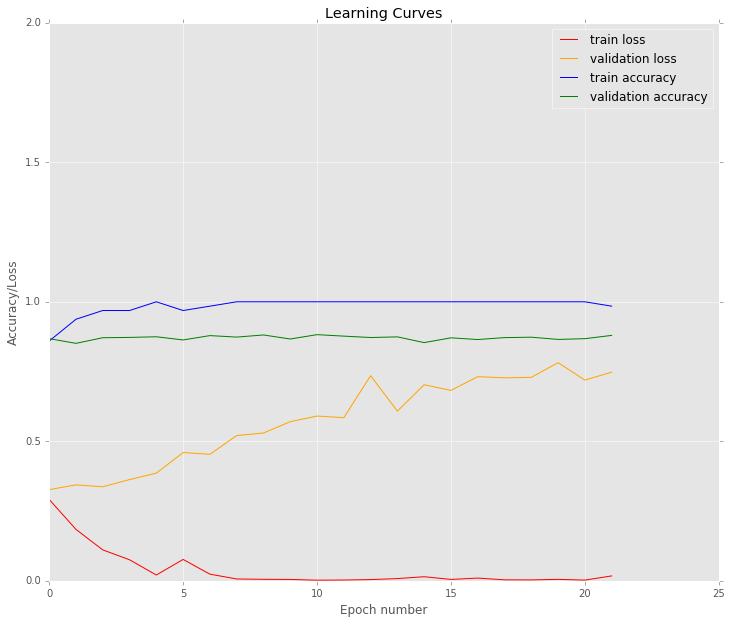

In [76]:
#plot the training + testing loss and accuracy
%matplotlib inline
plt.style.use("ggplot")
plt.figure()

num_epochs_trained = len(train_loss_log)
plt.plot(np.arange(0, num_epochs_trained), train_loss_log, label="train loss", c = "red")
plt.plot(np.arange(0, num_epochs_trained), val_loss_log, label="validation loss", c = "orange")
plt.plot(np.arange(0, num_epochs_trained), train_acc_log, label="train accuracy", c = "blue")
plt.plot(np.arange(0, num_epochs_trained), val_acc_log, label="validation accuracy", c = "green")

plt.title("Learning Curves")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy/Loss")
plt.ylim([0, 2])
plt.legend()

plt.gcf().set_size_inches((12, 10))
plt.show()